In [1]:
from pykoala.instruments.koala_ifu import koala_rss
from matplotlib import pyplot as plt
import numpy as np
from pykoala import __version__
import warnings
import importlib
# You may want to comment the following line
warnings.filterwarnings("ignore")
from pykoala.corrections.throughput import ThroughputCorrection
from pykoala.plotting.utils import qc_throughput

pyKOALA version:  0.14.2+4.gdaab03e.dirty


In [2]:
flat_rss = [koala_rss("data/combined_skyflat_red.fits")]
throughput_corr = ThroughputCorrection.from_rss(flat_rss, clear_nan=True,
                                                medfilt=100)

# apply the correction to the flat exposure
corrected_flat = throughput_corr.apply(flat_rss[0])

[pykoala] 2024/08/25 12:27|INFO> 
> Reading KOALA RSS file combined_skyflat_red.fits
[pykoala] 2024/08/25 12:27|INFO> Number of fibres in this RSS =1000No. of good fibres = 986No. of bad fibres = 14
[pykoala] 2024/08/25 12:27|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
Applying median filter (size=100 px)


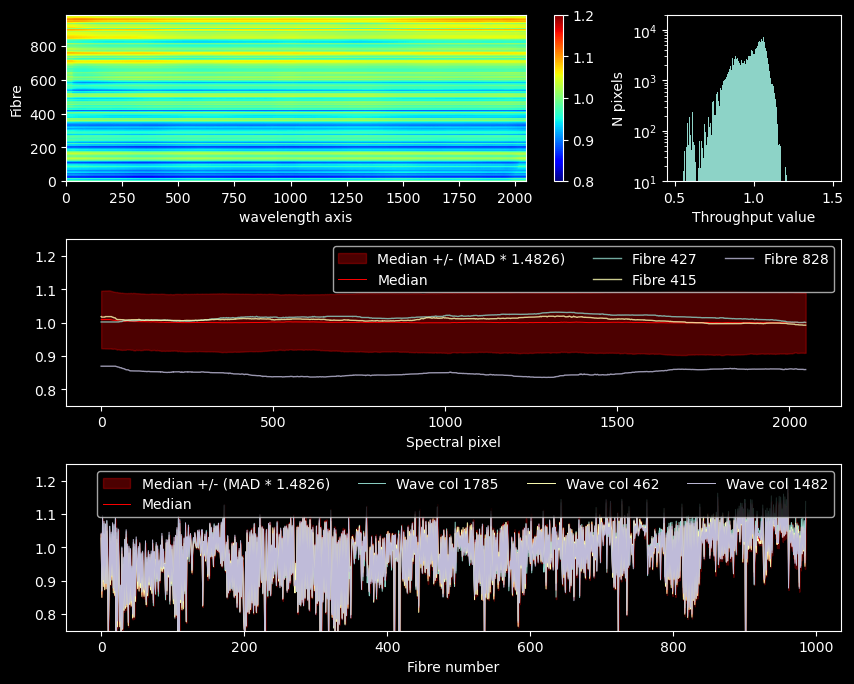

In [3]:
throughput_fig = qc_throughput(throughput_corr.throughput)
plt.show(throughput_fig)


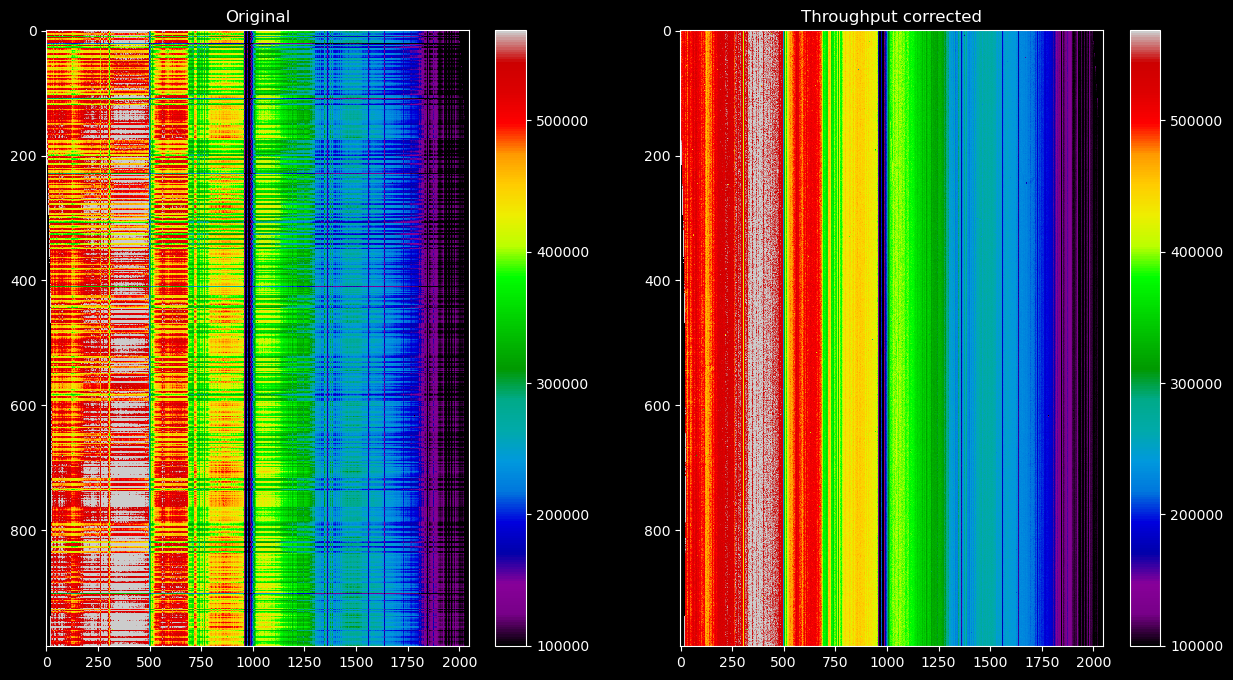

In [13]:
plt.figure(figsize=(15, 8))
plt.subplot(121, title='Original')
plt.imshow(flat_rss[0].intensity, interpolation='none', aspect='auto', cmap='nipy_spectral',
           vmin=np.nanpercentile(flat_rss[0].intensity, 5),
           vmax=np.nanpercentile(flat_rss[0].intensity, 95))
plt.colorbar()

plt.subplot(122, title='Throughput corrected')
plt.imshow(corrected_flat.intensity, interpolation='none', aspect='auto', cmap='nipy_spectral',
           vmin=np.nanpercentile(flat_rss[0].intensity, 5),
           vmax=np.nanpercentile(flat_rss[0].intensity, 95))
plt.colorbar()

# Use wavelength correction first

In [5]:
from pykoala.instruments.koala_ifu import koala_rss

from pykoala.corrections.wavelength import SolarCrossCorrOffset
from time import time
from pykoala.plotting.utils import fibre_map
from matplotlib import pyplot as plt
import numpy as np


[pykoala.correction.SolarCrossCorrelationOffset] 2024/08/25 12:28|INFO> Estimating regions of solar spectra dominated by absorption lines.
[pykoala.correction.SolarCrossCorrelationOffset] 2024/08/25 12:28|INFO> Number of pixels with non-zero weights: 1680 out of 2048
[pykoala.correction.SolarCrossCorrelationOffset] 2024/08/25 12:28|INFO> Including the masking of pixels dominated by telluric absorption
[pykoala.correction.SolarCrossCorrelationOffset] 2024/08/25 12:28|INFO> Computing grid of solar spectra models
[pykoala.correction.SolarCrossCorrelationOffset] 2024/08/25 12:28|INFO> Performing the cross-correlation with the grid of models
[pykoala.correction.SolarCrossCorrelationOffset] 2024/08/25 12:28|INFO> Inspecting input fibres


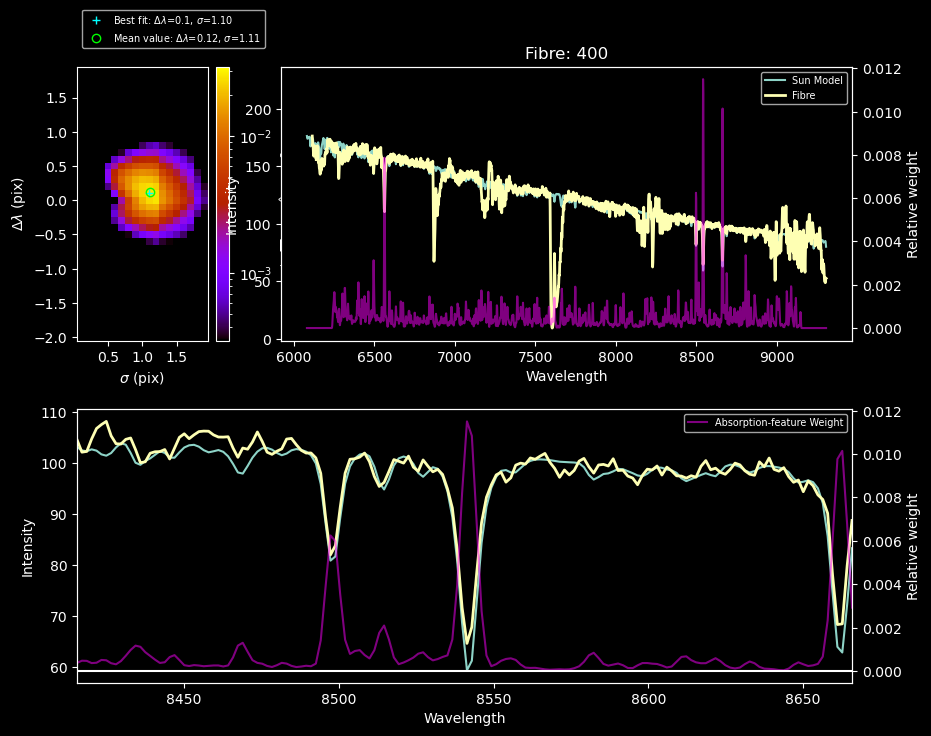

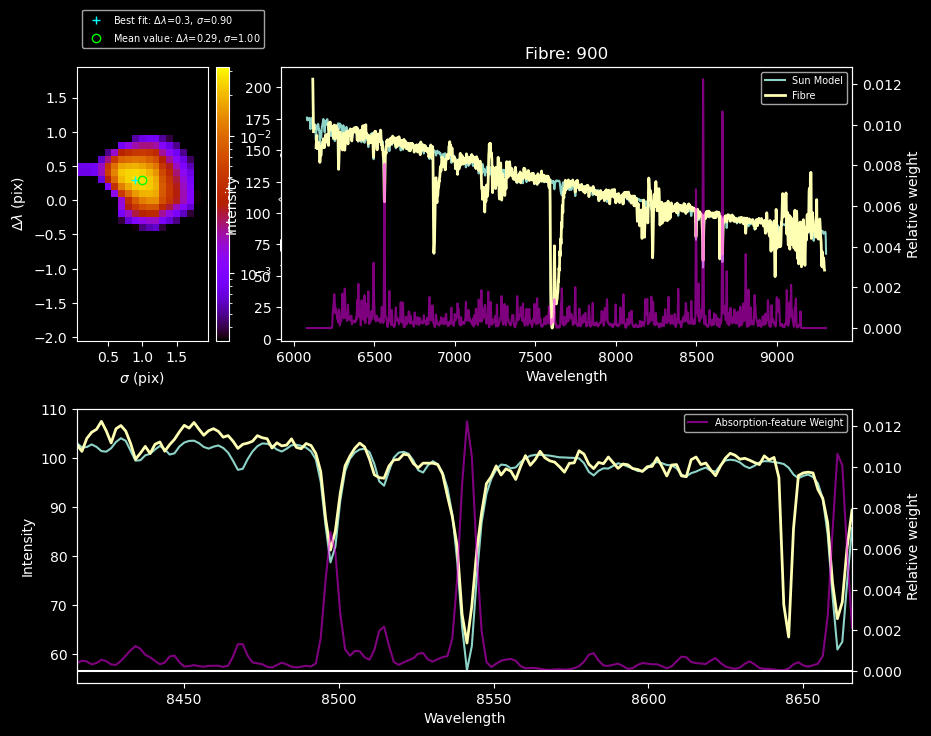

[pykoala.correction.SolarCrossCorrelationOffset] 2024/08/25 12:28|INFO> Using mean likelihood-weighted values to compute the wavelength offset correction


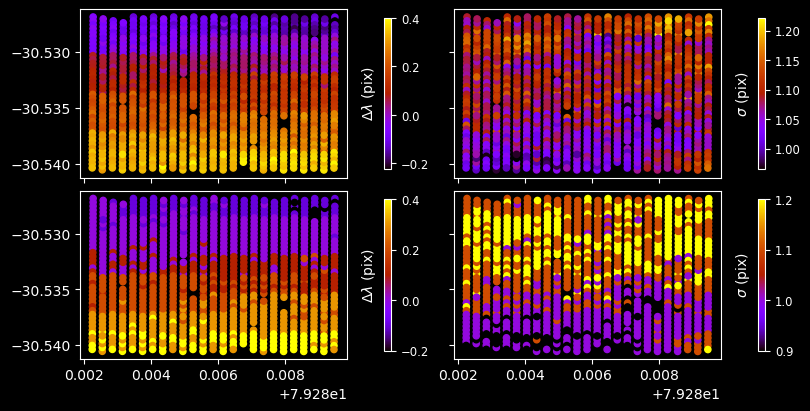

In [6]:
solar_correction = SolarCrossCorrOffset.from_fits()

solution = solar_correction.compute_shift_from_twilight(
    flat_rss[0], keep_features_frac=0.05,
    pix_shift_array=np.arange(-2, 2, 0.10),
    pix_std_array=np.arange(0.1, 2, 0.10),
    logspace=False, inspect_fibres=[400, 900])

rss_corrected = solar_correction.apply(flat_rss[0])



Text(0.5, 1.0, 'Best-fit LSF std')

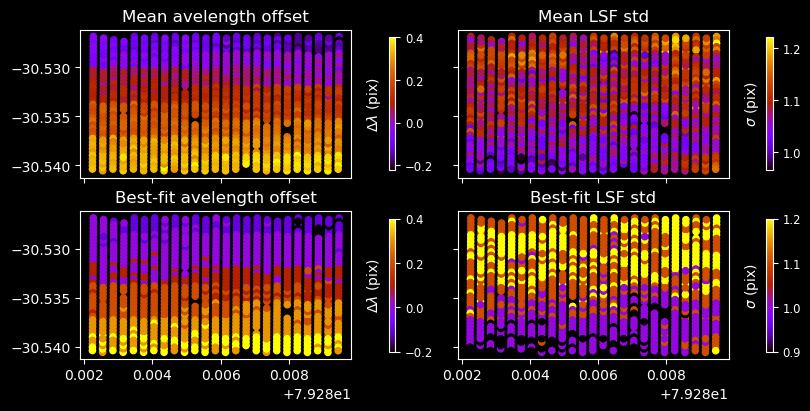

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=2, constrained_layout=True, sharex=True, sharey=True,
                        figsize=(8, 4))

fibre_map(fig, axs[0, 0], r'$\Delta\lambda$ (pix)', flat_rss[0], solution['mean'][0], norm=plt.Normalize(),
          cmap='gnuplot')
fibre_map(fig, axs[0, 1], r'$\sigma$ (pix)', flat_rss[0], solution['mean'][1], norm=plt.Normalize(),
          cmap='gnuplot')
fibre_map(fig, axs[1, 0], r'$\Delta\lambda$ (pix)', flat_rss[0], solution['best-fit'][0], norm=plt.Normalize(),
          cmap='gnuplot')
fibre_map(fig, axs[1, 1], r'$\sigma$ (pix)', flat_rss[0], solution['best-fit'][1], norm=plt.Normalize(),
          cmap='gnuplot')

axs[0, 0].set_title("Mean avelength offset")
axs[1, 0].set_title("Best-fit avelength offset")
axs[0, 1].set_title("Mean LSF std")
axs[1, 1].set_title("Best-fit LSF std")

In [7]:
throughput_corr = ThroughputCorrection.from_rss([rss_corrected], clear_nan=True,
                                                medfilt=100)
new_corrected_flat = throughput_corr.apply(rss_corrected)


Applying median filter (size=100 px)


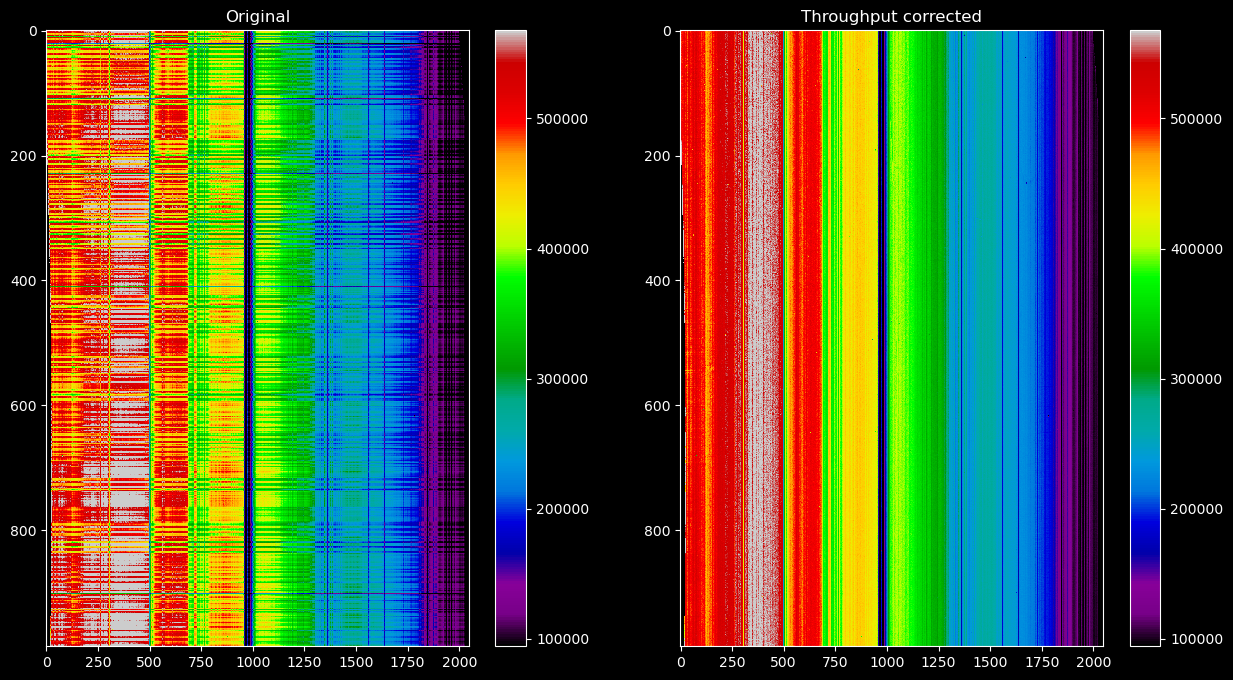

In [12]:
plt.figure(figsize=(15, 8))
plt.subplot(121, title='Original')
plt.imshow(rss_corrected.intensity, interpolation='none', aspect='auto', cmap='nipy_spectral',
           vmin=np.nanpercentile(rss_corrected.intensity, 5),
           vmax=np.nanpercentile(rss_corrected.intensity, 95))
plt.colorbar()

plt.subplot(122, title='Throughput corrected')
plt.imshow(new_corrected_flat.intensity, interpolation='none', aspect='auto', cmap='nipy_spectral',
           vmin=np.nanpercentile(rss_corrected.intensity, 5),
           vmax=np.nanpercentile(rss_corrected.intensity, 95))
plt.colorbar()

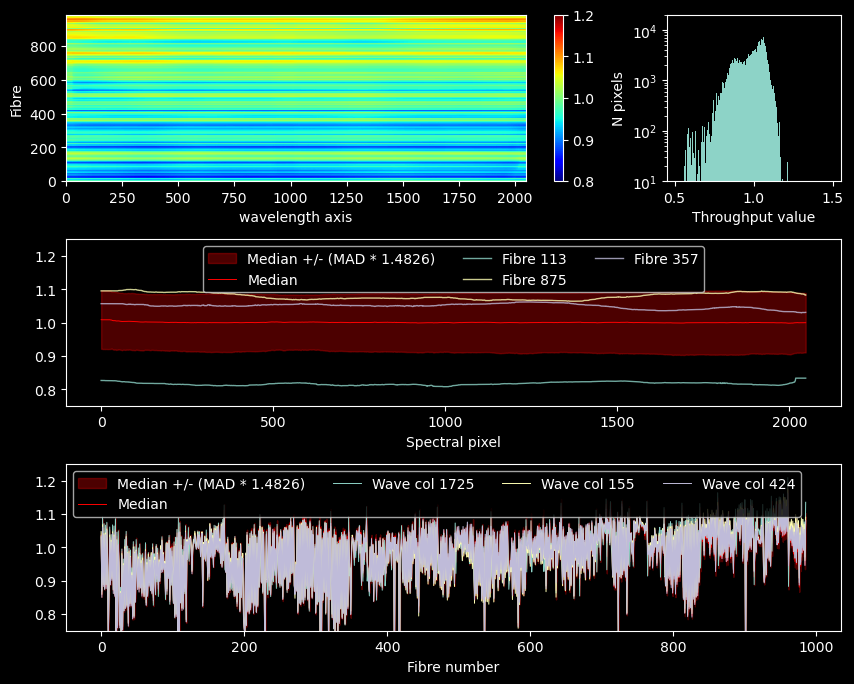

In [8]:
throughput_fig = qc_throughput(throughput_corr.throughput)
plt.show(throughput_fig)

(0.1, 2.0)

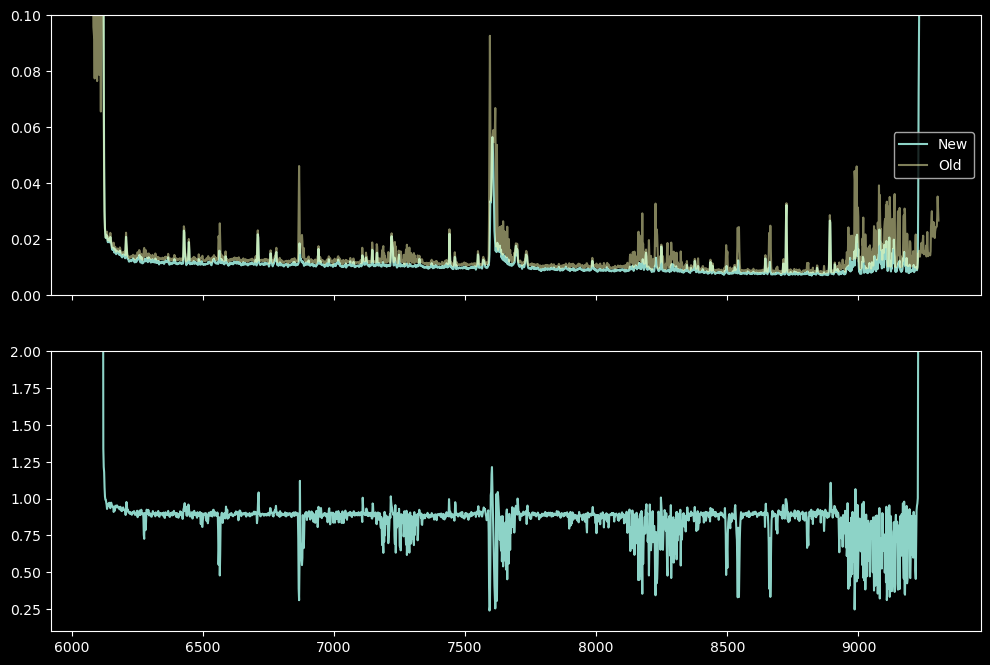

In [9]:
new_dispersion = np.nanstd(new_corrected_flat.intensity, axis=0) / np.nanmean(new_corrected_flat.intensity, axis=0)
old_dispersion = np.nanstd(corrected_flat.intensity, axis=0)  / np.nanmean(corrected_flat.intensity, axis=0)
fig, axs = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)
ax = axs[0]
ax.plot(new_corrected_flat.wavelength, new_dispersion, alpha=1, label='New')
ax.plot(corrected_flat.wavelength, old_dispersion, alpha=0.5, label='Old')
ax.set_ylim(0, 0.1)
ax.legend()
ax = axs[1]
ax.plot(corrected_flat.wavelength, np.nanstd(new_corrected_flat.intensity, axis=0) / np.nanstd(corrected_flat.intensity, axis=0))
#ax.set_yscale("log")
ax.set_ylim(0.1, 2)